In [1]:
import numpy as np
import random

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

#for live plotting
from IPython.display import clear_output
from matplotlib import pyplot as plt
%matplotlib inline

%run lipm_env.ipynb #imports LIPM Env

from py_bullet_env.bullet_solo_env import SoloBulletEnv

In [2]:
class Buffer:
    def __init__(self, buffer_size):
        
        self.buffer_size = buffer_size
        self.buffer = np.zeros((1, 2 + 1 + 1 + 2)) ## should be made variables
        
    def size(self):
        
        return len(self.buffer)
    
    def store(self, state, action, reward, next_state, done):
        ## stores new data in the buffer
        new_data = 9999*np.ones((1, 2 + 1 + 1 + 2))
        new_data[0, 0:2] = state
        new_data[0, 2:4] = [action, reward]
        if not done:
            new_data[0, 4:] = next_state 
        else:
            new_data[0, 4:] = [np.nan, np.nan]
        self.buffer = np.concatenate((self.buffer, np.around(new_data, 2)), axis = 0)
        
        #removes the first element if it is zero.
        if np.all(self.buffer[0] == 0):
            self.buffer = self.buffer[1:]
            
        # removes first element if the desired buffer size is obtained
        elif self.size() > self.buffer_size:
            self.buffer = self.buffer[1:]
            
    def sample(self, batch_size):
        # returns a random mini batch of desired batch size
        return np.asarray(random.sample(list(self.buffer), batch_size))

In [3]:
class NN(nn.Module):
    def __init__(self, inp_size, out_size):
        
        super(NN, self).__init__()
        self.l1 = nn.Linear(inp_size, 1024)
        self.l2 = nn.Linear(1024, 1024)
        self.l3 = nn.Linear(1024, out_size)
    
    def forward(self, x):
        
        x = F.relu(self.l1(x))
        x = F.relu(self.l2(x))
        x = self.l3(x)
        return x

In [4]:
class DQStepper:
    def __init__(self, no_actions = 9, lr = 1e-4, gamma = 0.9, use_tarnet = False, trained_model = None):
        
        self.device = torch.device("cpu")
        self.dq_stepper = NN(3, 1).to(self.device) #state+ action -> q_value
        if trained_model:
            self.dq_stepper.load_state_dict(torch.load(trained_model))
            self.dq_stepper.eval()
        self.optimizer = torch.optim.SGD(self.dq_stepper.parameters(), lr)
        self.use_tarnet = use_tarnet
        if self.use_tarnet:
            self.dq_tar_stepper = NN(3, 1).to(self.device)
            self.dq_tar_stepper.load_state_dict(self.dq_stepper.state_dict())
            self.dq_tar_stepper.eval()
        self.gamma = gamma #discount factor
        self.no_actions = no_actions
                
    def predict_action_value(self, x):
        # this function predicts the q_value for different actions and returns action and min q value
        x_in = np.tile([x[0], x[1], 0], (self.no_actions, 1))
        x_in[:,2] = np.arange(self.no_actions)
        torch_x_in = torch.FloatTensor(x_in, device = self.device)
        with torch.no_grad():
            q_values = self.dq_stepper(torch_x_in).detach().numpy()
        return np.argmin(q_values), q_values[np.argmin(q_values)]
    
    def tar_predict_action_value(self, x):
        # this function uses tar net to predict 
        # the q_value for different actions and returns action and min q value
        x_in = np.tile([x[0], x[1], 0], (self.no_actions, 1))
        x_in[:,2] = np.arange(self.no_actions)
        torch_x_in = torch.FloatTensor(x_in, device = self.device)
        with torch.no_grad():
            q_values = self.dq_tar_stepper(torch_x_in).detach().numpy()
        return np.argmin(q_values), q_values[np.argmin(q_values)]
    
    def predict_eps_greedy(self, x, eps = 0.1):
        # This function returns prediction based on epsillon greedy algorithm
        if np.random.random() > eps:
            return self.predict_action_value(x)[0]
        else:
            return np.random.randint(self.no_actions)
        
    def optimize(self, mini_batch, tau = 0.001):
        # This function performs one step of back propogation for the given mini_batch data
        x_in = torch.FloatTensor(mini_batch[:,0:3].copy(), device = self.device)
        y_train = torch.FloatTensor(mini_batch[:,3].copy(), device = self.device)
        for i in range(len(mini_batch)):
            if not np.isnan(mini_batch[i,4:]).all():
                if not self.use_tarnet:
                    y_train[i] += self.gamma * self.predict_action_value(mini_batch[i,4:])[1]
                else:
                    y_train[i] += self.gamma * self.tar_predict_action_value(mini_batch[i,4:])[1]

        y_train = y_train.unsqueeze(1).detach() #ensures that gradients are not computed on this
        x_train = self.dq_stepper(x_in)

        loss = F.mse_loss(x_train, y_train)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
        if self.use_tarnet:
            for tar_param, param in zip(self.dq_tar_stepper.parameters(), self.dq_stepper.parameters()):
                tar_param.data.copy_(tar_param.data * (1.0 - tau) + param.data * tau)
                
        return loss
    
    def live_plot(self, history, figsize=(7,5), title='history'):
        clear_output(wait=True)
        plt.figure(figsize=figsize)
        for label,data in history.items():
            plt.plot(data, label=label)
        plt.title(title)
        plt.grid(True)
        plt.xlabel('episode')
        plt.legend(loc='top right') # the plot evolves to the right
        plt.show();
        
    def predict_q(self, x):
        #for debugging
        # this function predicts the q_value for different actions and returns action and min q value
        x_in = np.tile([x[0], x[1], 0], (self.no_actions, 1))
        x_in[:,2] = np.arange(self.no_actions)
        torch_x_in = torch.FloatTensor(x_in, device = self.device)
        with torch.no_grad():
            q_values = self.dq_stepper(torch_x_in).detach().numpy()
        return q_values

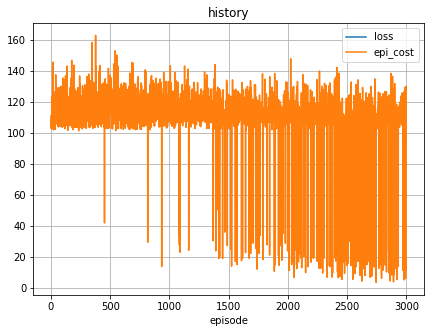

In [15]:
## This block is for training the dq stepper
buffer_size = 10000
buffer = Buffer(buffer_size)

dqs = DQStepper(lr=1e-4, gamma=0.98, use_tarnet= True)
batch_size = 16
epsillon = 0.2

e = 1
no_epi = 3000
no_steps = 10 ## number of steps simulated per episode (pendulum steps)
step_time = 0.1 ## time after which step is taken
env = LipmEnv(0.2, 0.22, [2, 2, 2])

history = {'loss':[], 'epi_cost':[]}
while e < no_epi:
    v_init = 8*(np.random.rand() - 0.5)
    state = env.reset_env([0.0, v_init], no_steps*step_time)
    if buffer.size() == buffer_size:
        history['epi_cost'].append(epi_cost)
#         history['loss'].append(loss)
        dqs.live_plot(history)
        e += 1
    epi_cost = 0
    for n in range(no_steps):
        action = dqs.predict_eps_greedy(state, epsillon)
        next_state, cost, done = env.step_env(action, step_time)
        buffer.store(state, action, cost, next_state, done)
        state = next_state
        
        if buffer.size() == buffer_size:
            ## optimizing DQN
            loss = dqs.optimize(buffer.sample(batch_size))            
            epi_cost += cost
        if done:
            break
        

In [16]:
# This block is to save the model
name = "dqs_2"
torch.save(dqs.dq_stepper.state_dict(), "../../models/" + name)

In [11]:
# this block is to load a stepper
dqs = DQStepper(lr=1e-4, gamma=0.98, use_tarnet= True, trained_model='../../models/dqs_1')

[[78.21116 ]
 [67.93159 ]
 [59.20666 ]
 [50.583458]
 [49.253544]
 [52.72021 ]
 [58.450344]
 [65.16695 ]
 [71.98729 ]]


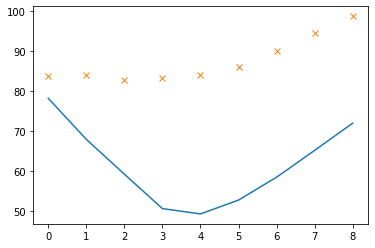

In [17]:
## visualising the q values
q_arr = []
q_arr.append(dqs.predict_q([0.0, 0.0]))
print(q_arr[0])

q_arr.append(dqs.predict_q([0, -1]))

plt.plot(q_arr[0])
plt.plot(q_arr[1], 'x')
plt.show()

In [20]:
no_steps = 10 ## number of steps simulated per episode (pendulum steps)
step_time = 0.1 ## time after which step is taken
env = LipmEnv(0.2, 0.22, [2, 2, 0])

state = env.reset_env([0.0, 1], no_steps*step_time)
epi_cost = 0
for n in range(no_steps):
    action, q_value = dqs.predict_action_value(state)
    print(action)
    next_state, cost, done = env.step_env(action, step_time)
    state = next_state
    epi_cost += cost
    if done:
        print(epi_cost)
        break
print("showing simulation...")  
env.show_episode(5, 1)

8
6
5
4
4
3
4
4
5
4
showing simulation...


<source type="video/mp4" src="data:video/mp4;base64,AAAAHGZ0eXBNNFYgAAACAGlzb21pc28yYXZjMQAAAAhmcmVlAAAyhG1kYXQAAAKuBgX//6rcRem9
5tlIt5Ys2CDZI+7veDI2NCAtIGNvcmUgMTUyIHIyODU0IGU5YTU5MDMgLSBILjI2NC9NUEVHLTQg
QVZDIGNvZGVjIC0gQ29weWxlZnQgMjAwMy0yMDE3IC0gaHR0cDovL3d3dy52aWRlb2xhbi5vcmcv
eDI2NC5odG1sIC0gb3B0aW9uczogY2FiYWM9MSByZWY9MyBkZWJsb2NrPTE6MDowIGFuYWx5c2U9
MHgzOjB4MTEzIG1lPWhleCBzdWJtZT03IHBzeT0xIHBzeV9yZD0xLjAwOjAuMDAgbWl4ZWRfcmVm
PTEgbWVfcmFuZ2U9MTYgY2hyb21hX21lPTEgdHJlbGxpcz0xIDh4OGRjdD0xIGNxbT0wIGRlYWR6
b25lPTIxLDExIGZhc3RfcHNraXA9MSBjaHJvbWFfcXBfb2Zmc2V0PS0yIHRocmVhZHM9OSBsb29r
YWhlYWRfdGhyZWFkcz0xIHNsaWNlZF90aHJlYWRzPTAgbnI9MCBkZWNpbWF0ZT0xIGludGVybGFj
ZWQ9MCBibHVyYXlfY29tcGF0PTAgY29uc3RyYWluZWRfaW50cmE9MCBiZnJhbWVzPTMgYl9weXJh
bWlkPTIgYl9hZGFwdD0xIGJfYmlhcz0wIGRpcmVjdD0xIHdlaWdodGI9MSBvcGVuX2dvcD0wIHdl
aWdodHA9MiBrZXlpbnQ9MjUwIGtleWludF9taW49MjUgc2NlbmVjdXQ9NDAgaW50cmFfcmVmcmVz
aD0wIHJjX2xvb2thaGVhZD00MCByYz1jcmYgbWJ0cmVlPTEgY3JmPTIzLjAgcWNvbXA9MC42MCBx
cG1pbj0wIHFwbWF4PTY5IHFwc3RlcD00IGlwX3JhdGlvPTEuNDAgYXE9MToxLjAwAIAAAAuDZYiE
ADP//vbsvgU1/Z/QlxEsxdpKcD4qpICAdzTAAAADAAB5FfwSZP1ApEW79P7K1lNNnT6vMgJVzxNy
y1nh82fcNSFUxOoQoFhnJyjaUuOXFLagWDjyYfM6p+8B+CqrcppjRO8QCJeF9kpQkW/gVcD8AAAD
AQ9XfOogZfRlC1m5zMmAnjlZc74GH954uJqZOvMhYeTn3xxWJ6QAa9sSV9g1eGvQufVuXb7Zm6cj
L8y93qg+RZYiTiy9sSfk4YN4gq/LdI67lUN7euRZ7wSzXgsdf5SB6j4I7+qQ75xUzPuCKpXFayO8
5gJoiFE2i1+jZ4nSDtSZvlrmD6FJok5y71/AQOMZvalRe3KnSHOgIH+qqjEhUInBOHIK6gkp71HX
4Bb6VST7H3MurtzCoiPu4Awk2JHJNiGqY8Ni/Vb7Pjtz/gDPrQkNCRMbj9/6Q3elYKDknCD44v4M
07iLEJssqChAem1yVvnIw/odJw6ESExUq3FCbVjGphqlmrB1abMR5aX+xrn75U4hdmD0lKOsOpkg
A4zqNmqHtgtEyJpNScpyM1FZDc/VEiJg0MumFP9SanTz181s0M8JAe6GNLs7iIwiHx4t00N9sGn6
fvYoaUYw6F4YJzcdMlVBpbC7eh71EWZJJyP2WKN0ToY3Rrn7gMHc61se4KUIXcsbDCOhPLrnR7tb
gdW+9BHRUd7VHW6+DIb25+Xc7eDqfac88G6gElB6yOp8vqBeoQhTXrGAtiJ4/Hwda+k3IK6dEv4Q
lAdByFFJ+tGOGULZpdDo1c9ZZyRCS2pnJi2qlylWxF7X0KA9HJLc+Z6z5ZpzgZwoFYHTHd5vlGCl
68BNhCX9eiGSIWxqx5+6I5uc1k68zS2jcekLSSne+535BjHzvgwCKU2F/k/S0HpvbZRKrwxl7ckX
AAADAAUHmP0+NyYUzvTEKM6HHJJyUn64ctQsAI0koHn3/eC/qeuVHCdKgg+Pm3g9iz379448J8AK
0ltFONTiug+zO1tkq5typvHM/6XHJ7AKX8J7dnJaIrtrqngFNctTI085UFYEKJMSAYP2FVIZLrdJ
v+OTCqHOLsg+pklCU6GUdz+N56xDPiX0pDEPDqFlu9Ulno1o3s40GkvkJAWkXAxjI4HXvYdjAGQ8
iJJCzmlYCP217g+A/9l2tCJBwox0t8QoMJVg7iFCStn14bS0kjeSQK41PbLDmOggNC0fsu+v+yXG
1J8XE4u2vIt6LjHTYqDbFRZPqdXZ/4gcTyiUTymg51Vu2pk4MSC/eF3WsVfbb17Nb7PKY4lKGDAV
GLxm31uWjW9wY0mmr4shrTl5m0/IclNPo4Qo0nnww8B1/dse74nnw4JfXnKaO34JdzHSFL2ze3hv
m5fkRkoG3O3bh6WrcwBHaZtCkuyRr+hRvO8RWfSl4VsZ6rKl6xImiznkRbw1KWz5hWqjqUy+94Ev
56akJFscfcrYUfRSMm7XG8ndZ3JRgexuDuBAOMao7PE28ZtAfPTeE/ERLsksQY5Uaxk1yGqaVlj6
kDPezLS0xlnj4YUM1cdQ02k3v9nk9x23uo8pzWF3j510OTvBSp7YU3A7MJksJ1Dmdf/VNpkjuAKS
rCv8DXIsuwBcNeNaOPuE4P9U711MNxLllrkMrwcHahdCq5pd3t7tWyLkVUr1aL5FDBehSQZMhXub
dU3ERrXe7YHeruuaoG/jBol8uokTnDUtm3G7osdnE53GSyWNUDOcZggUJGhZZ/vTshY+HszihJ30
3bDx4MuJB2XS9HTOTl0TzqkN/6fDdYF+P63cm42T3XzUAMafgfK49xSdq41z37fztBo15Q6sqtEn
lTVNDFGERWQHr7XfGiX1gUcWO9YAQd96xGa5jmRq7J68SxXO7SXLGM3x9xWMp9Y09Y1n8QxxIJ+E
WYVR0dlS0XJN8oY0AzDa9vreQJjpH0cL/rPauvZuZBuGaevcGEsnoT0jWU6hzEv4FzU84xB1WC8B
P3rswsuSMnCaDylaTjiipd7viLD01WWAzTklz5biyK8ZPstpi5IEiCc4belrUn1UZsz2mbGACu9B
/CAP3UdlbkcxCJekTssEuKp62n//Pnb7nwIixC602LP6eiPXcNZYnoREG6ZmewMWhxxoONt6RnZs
iGsGN9iMNZDG4trKDaP3FVRSk6mcsUOdFollynHjPlmVrsLEDFCkBFWHezh+ZvwhvvPFbJBV7DEe
Ps63YsiPNMaSXNTbjUJwxr1a508EYkU4ibapt5vhPcFKGnyJxvFCbfTsmVuH8UpVaot58mHJBQtc
Adc9L9v449Z6TZ3Ds8K+nUlIIfbBXtJzwqLmQ2yHk/VM3mDDrMAUHq+bhMRgahCUq5sgJZpL+BU0
mtTDo2YaE4wmIf3tAsirLgHnXipSc+AjP/8SsmAlehbQ+yx7sV59Rj+7+irK1QGzcxLXVLK0pXHX
BfYfs7/yJ3G09J3Y8kl89syu1p/oNDpOqPoGstzHbkd9z0GkrDjTNp3u/SLliAj3s8nF6s+WfvNz
ZFj4R/ZjHTcq9pf+hzTiEBzJb9r4hw3WMalk0I0NJzuAmmDYTzNz9pshLq/+K/apADgo7zXCBOOX
6MScsXxrMpHb8bkt48EjJ+kP+icJmkczmOC3dHjSASBloDZd4y0gAkTVpIetlSdQJPue/VfHwBPh
p0+LgVr/jUYBebp+cIFwcycIsgLGdZO7kXsJjm17YB20Xeyfad30tIi9RTGpP+IJqbPyhlm8ghM7
Zi0wKxTdL7o3PqhrzHGVH9cNckv34ninUZZAhFtQmkq46LLmjh8kPMiCwDoH2bdrBhXdpFtrhhMi
5S2W5I65Sy5dEaGaTK4B2PVHWl1lVkBCzvu777UP/dsvPhrYv2ATGMm1Rp8+rORFLdkZS50r18qX
zob9tNf3BYhKk4GECD1eO

In [5]:
## This block is to test the stepper in simulation with solo
kp = [100, 100, 100]
kd = [1, 1, 5]
kp_com = [0, 0, 100]
kd_com = [5, 5, 30]
kp_ang_com = [300, 300, 300]
kd_ang_com = [100, 100, 100]

step_time = 0.1
ht = 0.2
des_com = [0.2, 0, ht]
des_vel = [0, 0, 0]
x_ori = [0, 0, 0, 1]
x_angvel = [0, 0, 0]


solo_env = SoloBulletEnv(ht, step_time, kp, kd, kp_com, kd_com, kp_ang_com, kd_ang_com)

env = LipmEnv(0.2, 0.22, [2, 2, 0])
action_space = env.action_space
dqs = DQStepper(lr=1e-4, gamma=0.98, use_tarnet= True, trained_model='../../models/dqs_2')
action = [0, 0]

In [10]:
x, xd, u = solo_env.reset_env()
state_x = [x[0] - u[0], xd[0]]
state_y = [x[1] - u[1], xd[1]]

des_vel = [0.5, 0.0, 0]
solo_env.update_gains(kp, kd, kp_com, kd_com, [500, 500, 300], kd_ang_com)
solo_env.record("test")
for n in range(25):
    action[0] = action_space[dqs.predict_action_value(state_x)[0]] + u[0]
    action[1] = action_space[dqs.predict_action_value(state_y)[0]] + u[1]
    print(action, state_x)
    x, xd, u = solo_env.step_env(action, des_com, des_vel, x_ori, x_angvel)
    state_x = [x[0] - u[0], xd[0]]
    state_y = [x[1] - u[1], xd[1]]

[0.2, 0.0] [0.0, 0.0]
[0.255, -0.05499999999999999] [0.009999999999999981, 0.13]
[0.30000000000000004, -0.05499999999999999] [0.04000000000000001, 0.2]
[0.31500000000000006, -0.004999999999999977] [-0.010000000000000009, 0.28]
[0.31, 0.04000000000000001] [-0.02999999999999997, 0.25]
[0.31, 0.05500000000000002] [-0.010000000000000009, 0.19]
[0.375, 0.04] [0.010000000000000009, 0.27]
[0.44500000000000006, 0.09500000000000003] [0.06999999999999995, 0.28]
[0.46499999999999997, 0.15000000000000002] [-0.019999999999999962, 0.38]
[0.485, 0.1] [-0.010000000000000009, 0.4]
[0.59, 0.11500000000000002] [-0.010000000000000009, 0.48]
[0.62, 0.17500000000000002] [0.0, 0.48]
[0.61, 0.21000000000000002] [-0.04999999999999993, 0.37]
[0.62, 0.19] [-0.030000000000000027, 0.28]
[0.65, 0.22500000000000003] [-0.030000000000000027, 0.24]
[0.745, 0.29000000000000004] [0.07000000000000006, 0.22]
[0.745, 0.34] [-0.009999999999999898, 0.35]
[0.785, 0.31] [-0.010000000000000009, 0.39]
[0.87, 0.305] [0.0, 0.45]
[0